# Antenna Pattern Standard 

> We used SMAP patterns as our baseline. For more information about SMAP patterns see [L1-L3 Ancilliary Products](https://nsidc.org/sites/default/files/smap_anc_l1l3l4.pdf). Specifically, the bottom of page 6.

The naming convention is
```
CIMR-AP-BK-C1-TPv0.1.h5 
```
where
- `CIMR` is the name of the experiment (can be i.e., SMAP)
- `AP` stands for the Antenna Pattern
- `BK` stands for Backward (i.e., the Back-Half space of the pattern). Other possible value is `FR`
- `C1` is the horn name and number
- `TP` stands for grid. In this case it is $(\theta, \phi)$. 
- `v0.1` is the version number 

It contains the following fields
```
/                        Group
/Gain                    Group
/Gain/G1h                Dataset {2501, 2501}
/Gain/G1v                Dataset {2501, 2501}
/Gain/G2h                Dataset {2501, 2501}
/Gain/G2v                Dataset {2501, 2501}
/Gain/G3h                Dataset {2501, 2501}
/Gain/G3v                Dataset {2501, 2501}
/Gain/G4h                Dataset {2501, 2501}
/Gain/G4v                Dataset {2501, 2501}
/Grid                    Group
/Grid/phi                Dataset {2501, 2501}
/Grid/theta              Dataset {2501, 2501}
/Version                 Dataset {SCALAR}
```
[__Note__]: To see the structure of hdf5 file use: 
```
$ h5ls -r CIMR-AP-BK-C1-TP.h5 
```

## How to get the results below? 

The executable to convert the antenna patterns is located inside `src/cimr-grasp/cimr-grasp.py`. 

you will need to create a `AP` directory inside `dpr` and put there antenna patterns. But each pattern should get a directory for each band, i.e., if you want to run the code on L and C bands only, you will have to create the following directories (inside `/` of the repo): 
```
dpr/AP/L
dpr/AP/C
```
and put the corresponding antenna patterns inside of these directories. 

In practice, just go to S[&]T Google Drive for CIMR RGB and fetch [the archives (from here)](https://drive.google.com/drive/folders/17mhlrODuXrmlFvnhOpomt28p2WhZ3S84?usp=sharing) of patterns you want to parse and then unpack them inside `dpr/APR` and the aforementioned directories should be automatically created. 

In [1]:
import pathlib 
import re 
import glob 
import numbers 
import sys 

import numpy as np 
import scipy as sp 
import h5py 
import xarray as xr 
import matplotlib
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable


def load_hdf5_to_dict(hdf5_group):
    data_dict = {}
    for key, value in hdf5_group.items():
        if isinstance(value, h5py.Group):
            # If the value is a group, recursively call the function for the subgroup
            data_dict[key] = load_hdf5_to_dict(value)
        elif isinstance(value, h5py.Dataset):
            # If the value is a dataset, load the data into a NumPy array
            data_dict[key] = np.array(value)
        else:
            # If the value is an attribute, load it into the dictionary
            data_dict[key] = hdf5_group.attrs[key]

    return data_dict

# This is one is unnecessary I think
def reconstruct_data(array): 

    real_part = np.array([[elem[0] for elem in row] for row in array])
    imag_part = np.array([[elem[1] for elem in row] for row in array])
    
    return real_part + 1j * imag_part


def find_repo_root(start_path: pathlib.Path = None) -> pathlib.Path:
    # If no start path is provided, use the current working directory
    if start_path is None:
        start_path = pathlib.Path.cwd()
    
    # Convert to absolute path
    start_path = start_path.resolve()
    
    # Check each directory from the start path upwards to the root
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').is_dir():
            return parent
    
    raise FileNotFoundError("No .git directory found in any parent directories")

root_dir = find_repo_root()
#print(f"The root of the repo is: {repo_root}")

imgsdir = f"{root_dir}/output/imgs"
if not pathlib.Path(imgsdir).exists():
    pathlib.Path(imgsdir).mkdir() 
    print(f"Created {imgsdir}")

dict_keys(['Gain', 'Grid', 'Version'])


/tmp/ipykernel_30007/1161208609.py:22: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  pcm2 = axes[0].pcolor(theta, phi, Z_plt, shading='auto', cmap=cmap)
/tmp/ipykernel_30007/1161208609.py:26: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  pcm2 = axes[1].pcolor(theta, phi, Z_plt, shading='auto', cmap=cmap)
/tmp/ipykernel_30007/1161208609.py:31: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(pcm2, cax=cax)


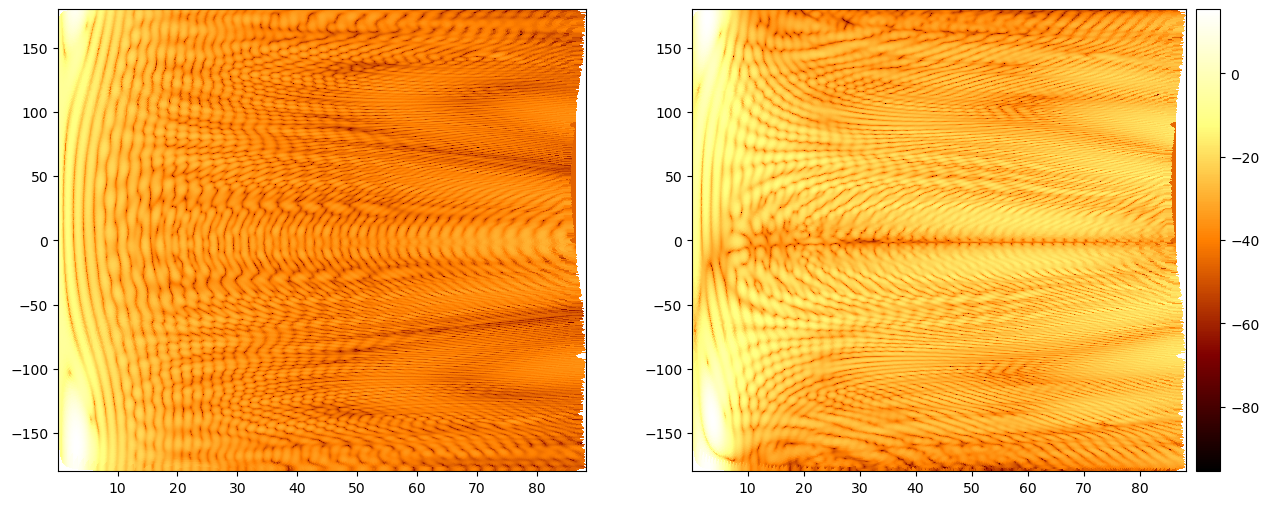

In [2]:
outfile_hdf = f"{root_dir}/output/parsed/CIMR-AP-FR-L1-TPv0.1.h5" 

# Open the HDF5 file and load it into a dictionary
with h5py.File(outfile_hdf, 'r') as hdf5_file:
    cimr = load_hdf5_to_dict(hdf5_file)

print(cimr.keys())

theta = cimr['Grid']['theta']
phi   = cimr['Grid']['phi']

Ghh = cimr['Gain']['G1h'] + 1j * cimr['Gain']['G2h'] 
Ghv = cimr['Gain']['G3h'] + 1j * cimr['Gain']['G4h'] 
Gvv = cimr['Gain']['G1v'] + 1j * cimr['Gain']['G2v']
Gvh = cimr['Gain']['G3v'] + 1j * cimr['Gain']['G4v']


#G[0, 0] = np.abs(Gvv)**2 
cmap = plt.get_cmap('afmhot')
fig, axes = plt.subplots(1, 2, figsize=(15,6)) 
Z_plt = 10 * np.log10(np.abs(Ghh)**2)
pcm2 = axes[0].pcolor(theta, phi, Z_plt, shading='auto', cmap=cmap)
#axes[0].set_title(r'Band: C, Horn: 1, Half-Space: Both $(|R_x|^2 + |C_x|^2)$')

Z_plt = 10 * np.log10(np.abs(Ghv)**2)
pcm2 = axes[1].pcolor(theta, phi, Z_plt, shading='auto', cmap=cmap)

# Create a shared color bar
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm2, cax=cax)

plt.savefig(f'{imgsdir}/CIMR-AP-FR-C1-TPv0.1.png', dpi=300) 
plt.show()

dict_keys(['Gain', 'Grid', 'Version'])


/tmp/ipykernel_30007/1572759726.py:30: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(pcm2, cax=cax)


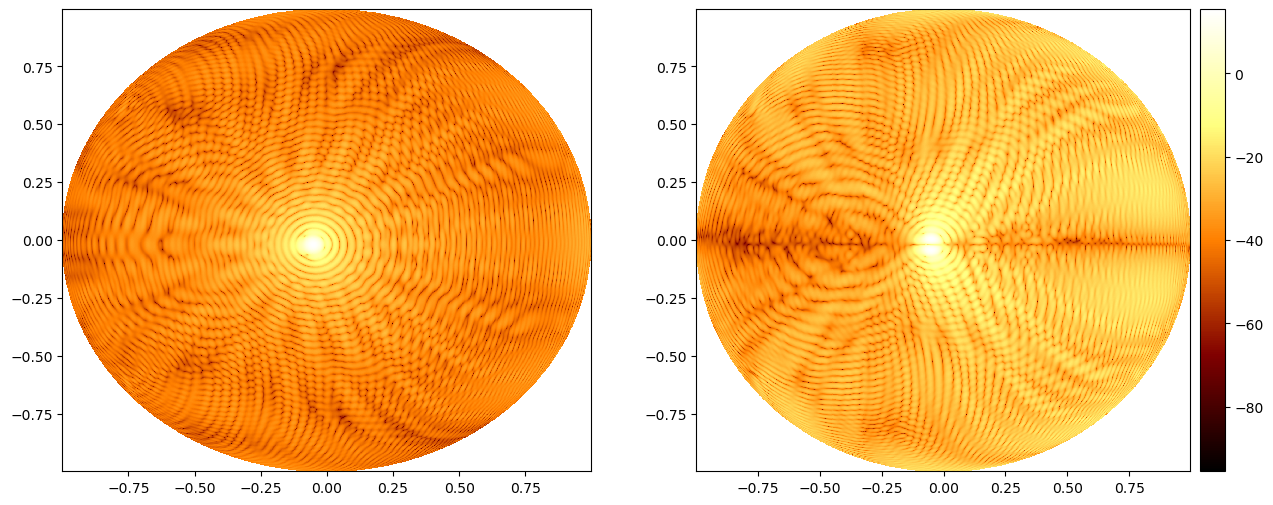

In [3]:
outfile_hdf = f"{root_dir}/output/parsed/CIMR-AP-FR-L1-UVv0.1.h5" 

# Open the HDF5 file and load it into a dictionary
with h5py.File(outfile_hdf, 'r') as hdf5_file:
    cimr = load_hdf5_to_dict(hdf5_file)

print(cimr.keys())

Ghh = cimr['Gain']['G1h'] + 1j * cimr['Gain']['G2h'] 
Ghv = cimr['Gain']['G3h'] + 1j * cimr['Gain']['G4h'] 
Gvv = cimr['Gain']['G1v'] + 1j * cimr['Gain']['G2v']
Gvh = cimr['Gain']['G3v'] + 1j * cimr['Gain']['G4v']

u = cimr['Grid']['u']
v = cimr['Grid']['v']

#G[0, 0] = np.abs(Gvv)**2 
cmap = plt.get_cmap('afmhot')
fig, axes = plt.subplots(1, 2, figsize=(15,6)) 
Z_plt = 10 * np.log10(np.abs(Ghh)**2)
pcm2 = axes[0].pcolor(u, v, Z_plt, shading='auto', cmap=cmap)
#axes[0].set_title(r'Band: C, Horn: 1, Half-Space: Both $(|R_x|^2 + |C_x|^2)$')

Z_plt = 10 * np.log10(np.abs(Ghv)**2)
pcm2 = axes[1].pcolor(u, v, Z_plt, shading='auto', cmap=cmap)

# Create a shared color bar
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm2, cax=cax)

plt.savefig(f'{imgsdir}/CIMR-AP-FR-C1-UVv0.1.png', dpi=300) 
plt.show()